/Users/ashikurrahmanshihab/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:32:32 - cmdstanpy - INFO - Chain [1] start processing
09:32:32 - cmdstanpy - INFO - Chain [1] done processing
09:32:32 - cmdstanpy - INFO - Chain [1] start processing
09:32:32 - cmdstanpy - INFO - Chain [1] done processing


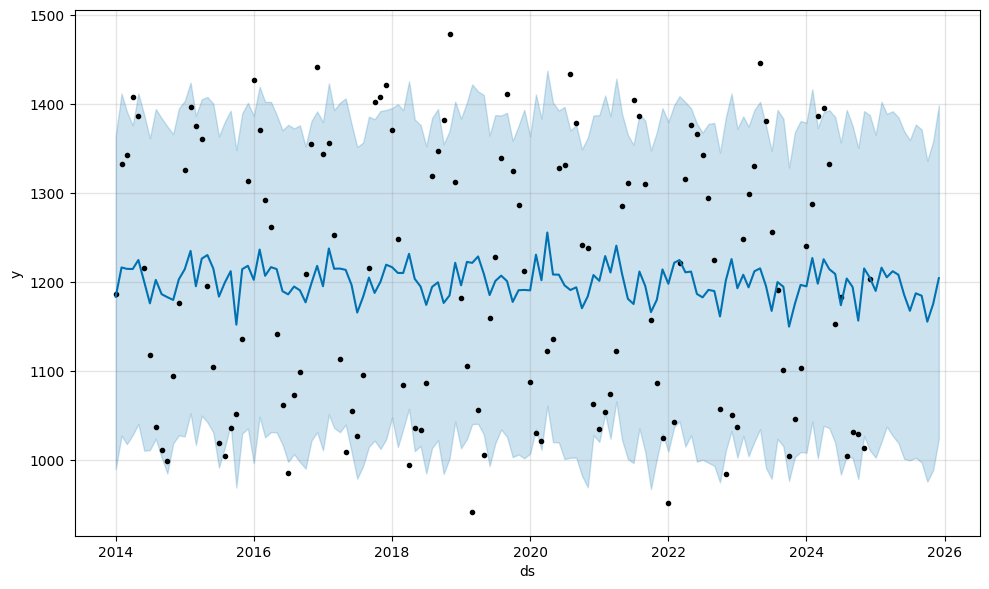

In [1]:
# ---------------------------------------------
# AROPHET: Hybrid Forecasting + ROP Calculation
# Combining Prophet + ARIMA for Pharma Sales
# ---------------------------------------------

# --- Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load Sales Data ---
file_path = "/Users/ashikurrahmanshihab/GitHub/Hybrid-Demand-Forecasting-and-Reorder-Point-Planning-Using-AROPHET-in-the-Pharmaceutical-Industry/Alton_20_Sales_Data_2014_2024.xlsx"
sales_data = pd.read_excel(file_path)

# --- Preview Raw Data ---
sales_data.head()

# --- Initialize Prophet Model with External Regressors ---
m = Prophet()
m.add_regressor('marketing_spend')
m.add_regressor('doctor_visits')
m.add_regressor('disease_trend')
m.add_regressor('stock_level')

# --- Fit Model ---
m.fit(sales_data.rename(columns={"ds": "ds", "y": "y"}))

# --- Clean Raw Data for Forecasting ---
df_raw = pd.read_excel(file_path)

# If the first row is not actual headers
if df_raw.iloc[0, 0] == "Month":
    df_clean = df_raw.iloc[1:].reset_index(drop=True)
else:
    df_clean = df_raw.copy()

# Keep only 'Date' and 'Sales' columns
df_clean = df_clean.iloc[:, :2]
df_clean.columns = ['ds', 'y']

# Clean sales column to retain only numeric values
df_clean['y'] = (
    df_clean['y'].astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .replace('', pd.NA)
    .astype(float)
)

# Convert date column
df_clean['ds'] = pd.to_datetime(df_clean['ds'], errors='coerce')
df_clean.dropna(inplace=True)

# --- Prophet Forecasting (Univariate) ---
model = Prophet(yearly_seasonality=True)
model.fit(df_clean)

future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)
forecast_2025 = forecast[forecast['ds'].dt.year == 2025].copy()

# --- Future Regressor Forecasting (Multivariate Prophet) ---
future = m.make_future_dataframe(periods=12, freq='MS')
future = pd.merge(future, sales_data, on='ds', how='left')

# Forward-fill regressors
for col in ['marketing_spend', 'doctor_visits', 'disease_trend', 'stock_level']:
    future[col] = future[col].ffill()

forecast = m.predict(future)
m.plot(forecast)
plt.show()

# Continue to bootstrapped confidence intervals and hybrid modeling in next message...


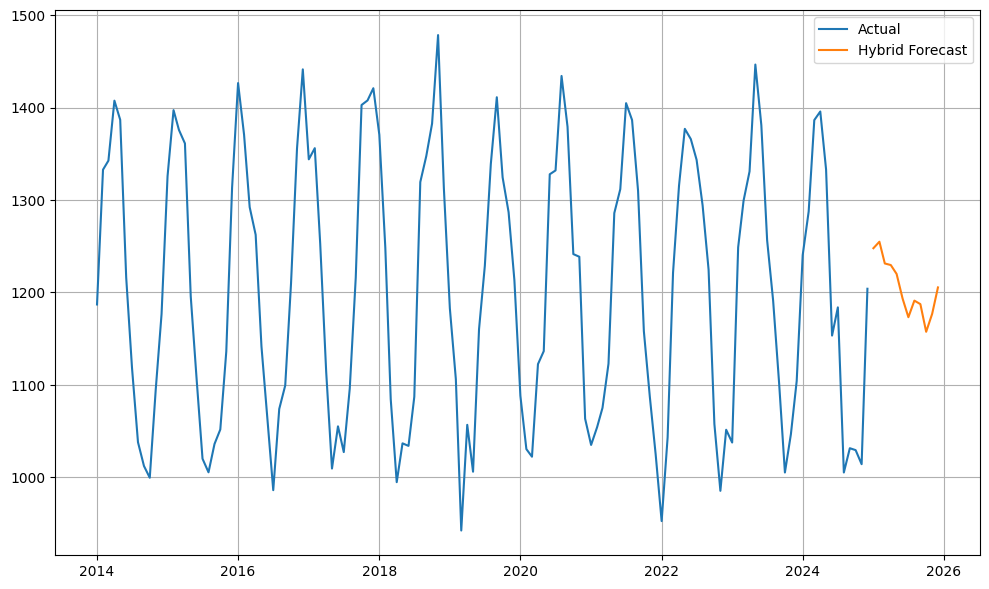

In [2]:
# --- Step 3: Bootstrapped Confidence Intervals for Prophet Forecast ---

# Merge actual and forecast to get residuals
df_with_yhat = pd.merge(df_clean, forecast[['ds', 'yhat']], on='ds')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']
residuals = df_with_yhat['residual'].values

# Generate 1000 bootstrapped forecasts for 2025
boot_samples = []
for _ in range(1000):
    sampled_residuals = np.random.choice(residuals, size=12, replace=True)
    simulated = forecast_2025['yhat'].values + sampled_residuals
    boot_samples.append(simulated)

boot_array = np.array(boot_samples)
forecast_2025['boot_lower'] = np.percentile(boot_array, 2.5, axis=0)
forecast_2025['boot_upper'] = np.percentile(boot_array, 97.5, axis=0)
forecast_2025['boot_median'] = np.percentile(boot_array, 50, axis=0)

# --- Step 4: Reorder Point (ROP) Calculation with Prophet Forecast ---
k = 1.0  # risk parameter (higher = more conservative inventory)
forecast_2025['prophet_rop'] = forecast_2025['boot_median'] + k * (
    forecast_2025['boot_upper'] - forecast_2025['boot_median']
)

# --- Step 5: ARIMA on Prophet Residuals ---
sales_data['forecast'] = m.predict(sales_data)['yhat']
sales_data['residuals'] = sales_data['y'] - sales_data['forecast']

# Fit ARIMA(1,0,1) on residuals
model_arima = ARIMA(sales_data['residuals'], order=(1, 0, 1))
model_arima_fit = model_arima.fit()

# Forecast next 12 months residuals
arima_forecast = model_arima_fit.forecast(steps=12)

# --- Step 6: Hybrid Model = Prophet + ARIMA Residuals ---
arima_model = ARIMA(df_with_yhat['residual'], order=(1, 0, 1)).fit()
arima_pred = arima_model.forecast(steps=12)
forecast_2025['arima_correction'] = arima_pred.values

# Hybrid forecast: combine both
final_forecast = forecast.tail(12).copy()
final_forecast['yhat_hybrid'] = final_forecast['yhat'] + arima_forecast.values

# Plot Hybrid Forecast
plt.figure(figsize=(10, 6))
plt.plot(sales_data['ds'], sales_data['y'], label='Actual')
plt.plot(final_forecast['ds'], final_forecast['yhat_hybrid'], label='Hybrid Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# --- Step 7: AROPHET Final Forecast (Prophet + ARIMA) ---
forecast_2025['arophet'] = forecast_2025['yhat'] + forecast_2025['arima_correction']

# --- Step 8: Bootstrapped ROP from AROPHET ---
boot_arophet_samples = []
for _ in range(1000):
    boot_resid = np.random.choice(residuals, size=12, replace=True)
    sim = forecast_2025['arophet'].values + boot_resid
    boot_arophet_samples.append(sim)

boot_arophet_array = np.array(boot_arophet_samples)
forecast_2025['arophet_lower'] = np.percentile(boot_arophet_array, 2.5, axis=0)
forecast_2025['arophet_upper'] = np.percentile(boot_arophet_array, 97.5, axis=0)
forecast_2025['arophet_median'] = np.percentile(boot_arophet_array, 50, axis=0)

forecast_2025['arophet_rop'] = forecast_2025['arophet_median'] + k * (
    forecast_2025['arophet_upper'] - forecast_2025['arophet_median']
)

# --- Step 9: Forecast Accuracy Comparison ---
actual = df_clean['y'].values
prophet_pred = forecast.loc[forecast['ds'].isin(df_clean['ds']), 'yhat'].values
arima_correction_hist = arima_model.predict(start=0, end=len(df_clean) - 1)
arophet_pred = prophet_pred + arima_correction_hist

# Accuracy metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = {
    'Model': ['Prophet', 'AROPHET'],
    'MAE': [mean_absolute_error(actual, prophet_pred),
            mean_absolute_error(actual, arophet_pred)],
    'RMSE': [np.sqrt(mean_squared_error(actual, prophet_pred)),
             np.sqrt(mean_squared_error(actual, arophet_pred))],
    'MAPE': [mape(actual, prophet_pred), mape(actual, arophet_pred)],
    'R2': [r2_score(actual, prophet_pred), r2_score(actual, arophet_pred)]
}

accuracy_df = pd.DataFrame(metrics)
print("Forecast Accuracy Comparison:")
print(accuracy_df)


Forecast Accuracy Comparison:
     Model         MAE        RMSE       MAPE        R2
0  Prophet  128.140214  143.799781  10.863618  0.017636
1  AROPHET   66.581900   84.591150   5.638436  0.660057


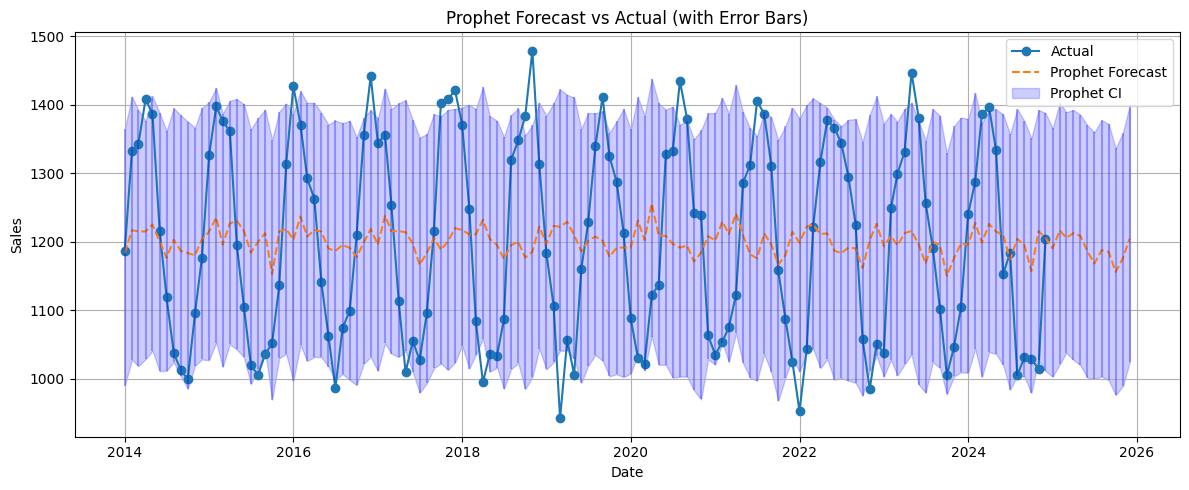

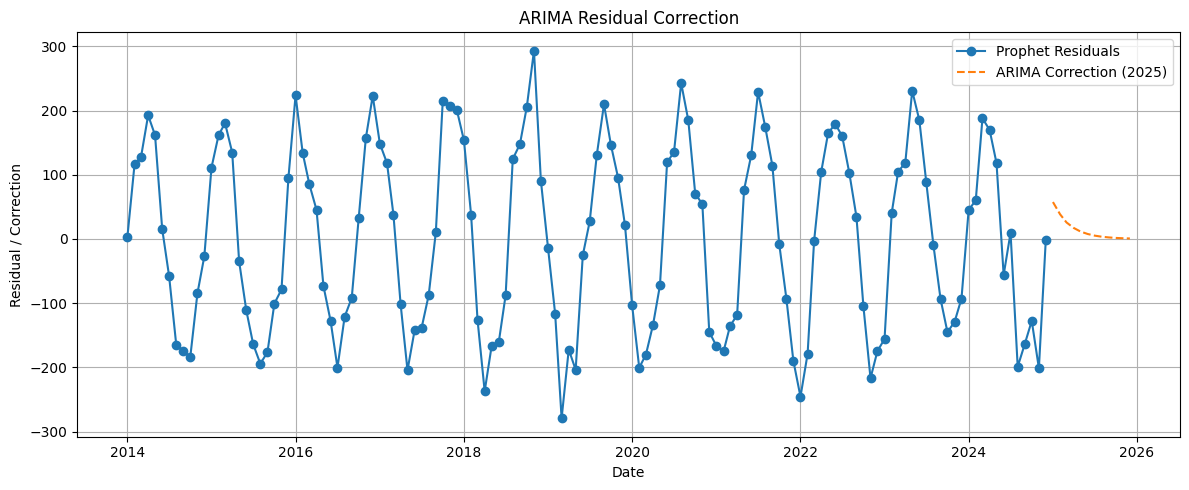

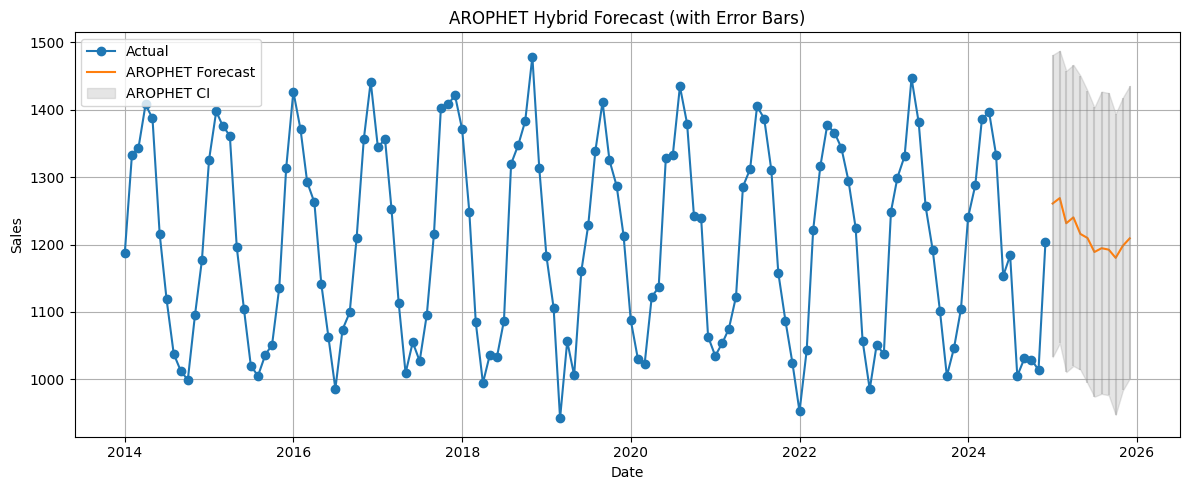

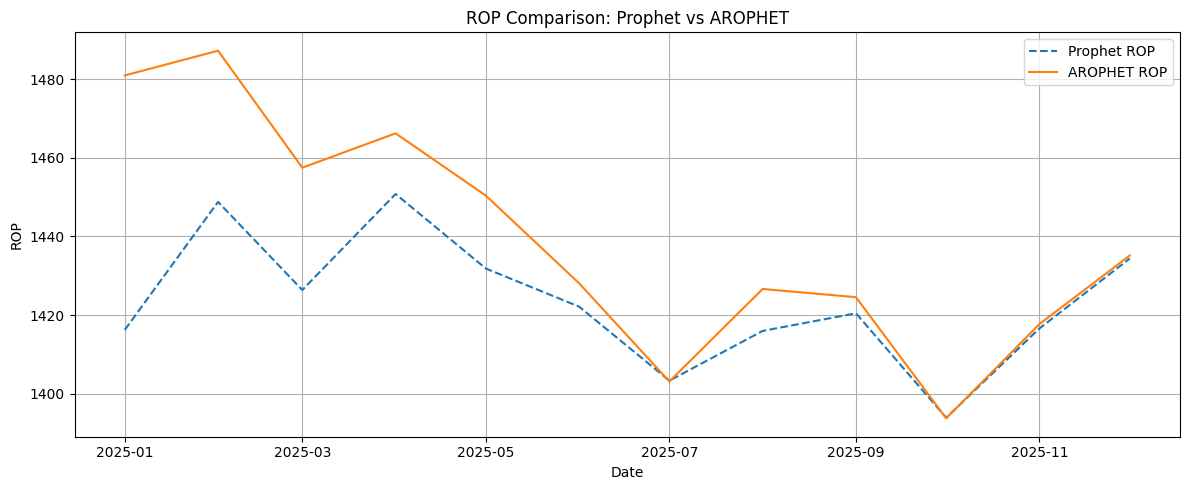

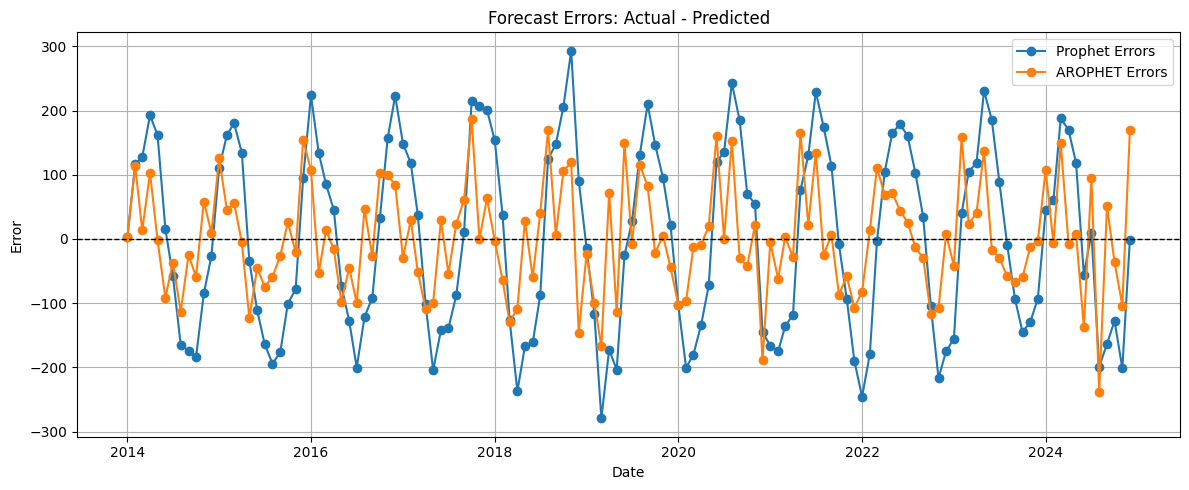

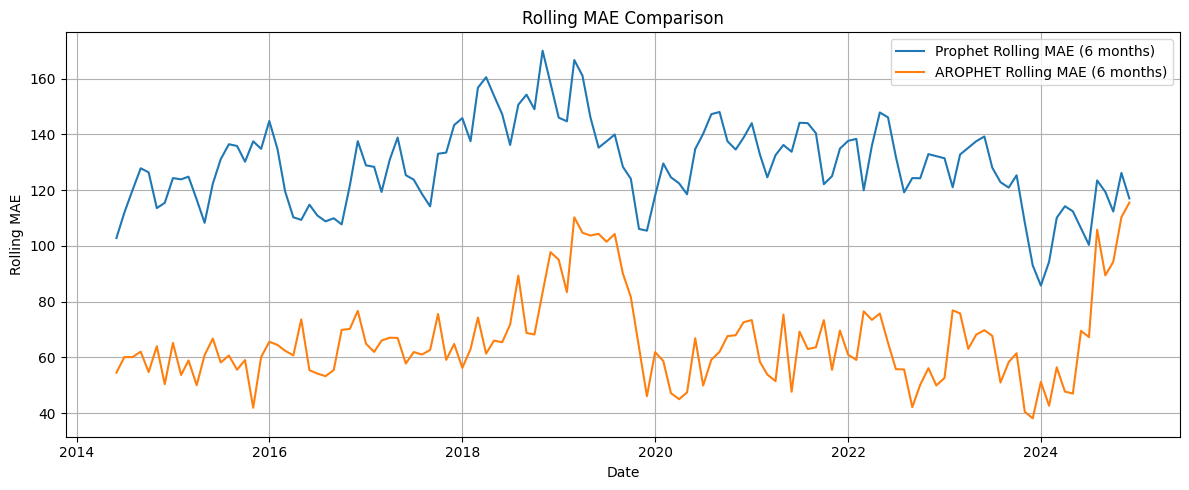

In [4]:
# --- Plot 1: Prophet Forecast with Error Bars ---
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='blue', alpha=0.2, label='Prophet CI')
plt.errorbar(forecast['ds'], forecast['yhat'],
             yerr=[forecast['yhat'] - forecast['yhat_lower'],
                   forecast['yhat_upper'] - forecast['yhat']],
             fmt='none', ecolor='blue', alpha=0.3)
plt.title('Prophet Forecast vs Actual (with Error Bars)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: ARIMA Residual Correction ---
plt.figure(figsize=(12, 5))
plt.plot(df_with_yhat['ds'], df_with_yhat['residual'], label='Prophet Residuals', marker='o')
plt.plot(pd.date_range(df_with_yhat['ds'].iloc[-1], periods=13, freq='MS')[1:],
         arima_pred, label='ARIMA Correction (2025)', linestyle='--')
plt.title('ARIMA Residual Correction')
plt.xlabel('Date')
plt.ylabel('Residual / Correction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 3: AROPHET Hybrid Forecast with Error Bars ---
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-')
plt.fill_between(forecast_2025['ds'], forecast_2025['arophet_lower'], forecast_2025['arophet_upper'],
                 color='gray', alpha=0.2, label='AROPHET CI')
plt.errorbar(forecast_2025['ds'], forecast_2025['arophet_median'],
             yerr=[forecast_2025['arophet_median'] - forecast_2025['arophet_lower'],
                   forecast_2025['arophet_upper'] - forecast_2025['arophet_median']],
             fmt='none', ecolor='gray', alpha=0.3)
plt.title('AROPHET Hybrid Forecast (with Error Bars)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 4: Reorder Point (ROP) Comparison ---
plt.figure(figsize=(12, 5))
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='Prophet ROP', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_rop'], label='AROPHET ROP', linestyle='-')
plt.title('ROP Comparison: Prophet vs AROPHET')
plt.xlabel('Date')
plt.ylabel('ROP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 5: Forecast Errors (Actual - Predicted) ---
prophet_errors = actual - prophet_pred
arophet_errors = actual - arophet_pred

plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], prophet_errors, label='Prophet Errors', marker='o')
plt.plot(df_clean['ds'], arophet_errors, label='AROPHET Errors', marker='o')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Forecast Errors: Actual - Predicted')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 6: Rolling MAE Comparison ---
window = 6
rolling_mae_prophet = pd.Series(np.abs(prophet_errors)).rolling(window).mean()
rolling_mae_arophet = pd.Series(np.abs(arophet_errors)).rolling(window).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], rolling_mae_prophet, label=f'Prophet Rolling MAE ({window} months)')
plt.plot(df_clean['ds'], rolling_mae_arophet, label=f'AROPHET Rolling MAE ({window} months)')
plt.title('Rolling MAE Comparison')
plt.xlabel('Date')
plt.ylabel('Rolling MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import plotly.express as px
import plotly.graph_objects as go

# Interactive Plot - Actual vs Forecasted Sales
fig = px.line(df_clean, x='ds', y='y', title='Actual vs Forecasted Sales')

# Add Prophet forecast
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Prophet Forecast', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', line=dict(dash='dot', color='lightgrey'), showlegend=False))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', line=dict(dash='dot', color='lightgrey'), fill='tonexty', fillcolor='rgba(200,200,200,0.2)', showlegend=False))

fig.write_html("actual_vs_forecast.html")  # Saves the interactive HTML


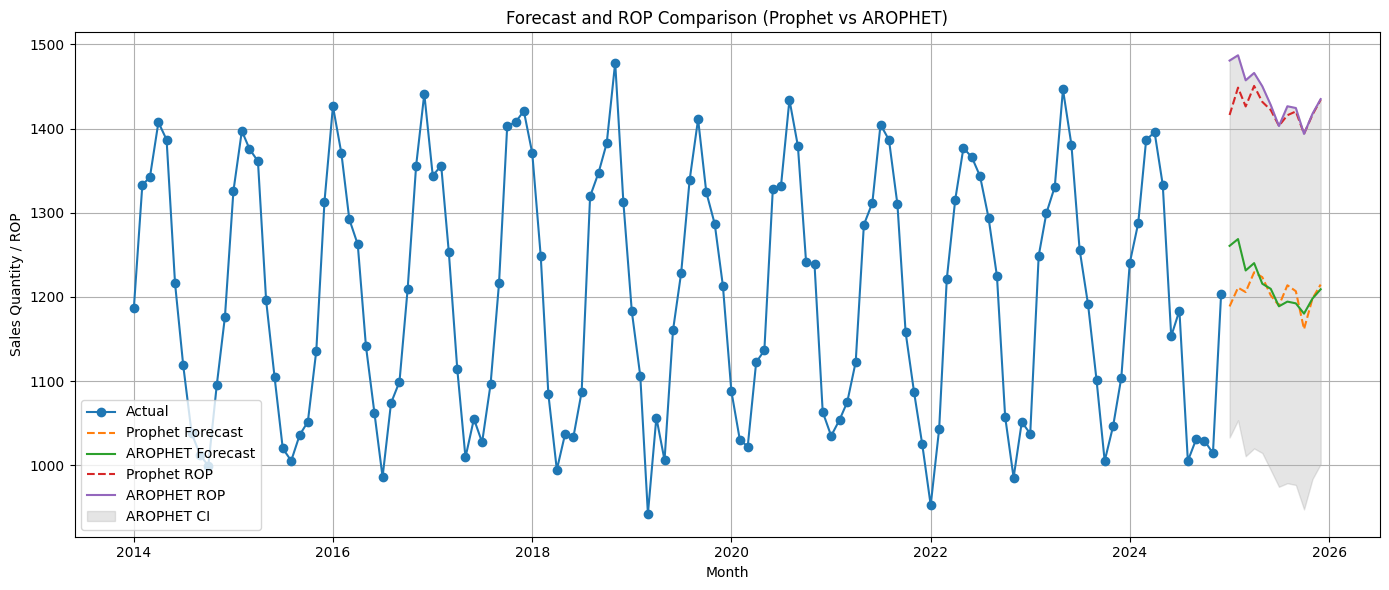

In [6]:
# --- Final Summary Plot: Forecast + ROP Combined ---
plt.figure(figsize=(14, 6))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o')
plt.plot(forecast_2025['ds'], forecast_2025['boot_median'], label='Prophet Forecast', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-')
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='Prophet ROP', linestyle='--')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_rop'], label='AROPHET ROP', linestyle='-')
plt.fill_between(forecast_2025['ds'], forecast_2025['arophet_lower'], forecast_2025['arophet_upper'],
                 color='gray', alpha=0.2, label='AROPHET CI')
plt.title("Forecast and ROP Comparison (Prophet vs AROPHET)")
plt.xlabel("Month")
plt.ylabel("Sales Quantity / ROP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
